<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/deeper/dp_onetwo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GD_12  
https://pytorch.org/tutorials/beginner/translation_transformer.html

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-91b_itj6/kobert-tokenizer_b130f2b1f79d48478714a8a578f7b943
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-91b_itj6/kobert-tokenizer_b130f2b1f79d48478714a8a578f7b943


In [ ]:
import numpy as np
import torch
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
from torch import optim
import random
from tqdm.notebook import tqdm
import re

In [ ]:
from torch import Tensor
from torch.nn import Transformer
import math

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from transformers import XLNetTokenizer
from kobert_tokenizer import KoBERTTokenizer

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
!python3 -m pip install konlpy

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/v0.6.0/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
git is already the newest version (1:2.17.1-1ubuntu0.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [ ]:
from konlpy.tag import Mecab

In [ ]:
import gensim

In [ ]:
from typing import List, Set, Dict, Tuple, Optional

데이터 불러오기 및 전처리

In [ ]:
my_url = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'
my_path = '/content/ChatbotData.csv'
torchtext.utils.download_from_url(my_url,my_path)

'/content/ChatbotData.csv'

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()

    sentence = re.sub(r"([?.!,¿¡])", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+)", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,¿¡]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [ ]:
my_data = pd.read_csv(my_path).drop_duplicates().applymap(lambda x : x if type(x) is int else preprocess_sentence(x))

In [ ]:
my_w2v = gensim.models.Word2Vec.load('/content/drive/MyDrive/colabdata/aiffel/ex_seven/data/ko.bin')

In [ ]:
len(my_w2v.wv.vocab)

30185

In [ ]:
max_len = 50

In [ ]:
mecab = Mecab()

In [ ]:
my_data['Q']=my_data['Q'].apply(mecab.morphs)
my_data['A']=my_data['A'].apply(mecab.morphs)

In [ ]:
print(my_data['Q'].apply(len).max())
print(my_data['A'].apply(len).max())

32
40


In [ ]:
import random
import copy
def my_augment(seq:List[str]):
  target_idx = random.randrange(0,len(seq))
  loop = 0
  while (seq[target_idx] not in my_w2v.wv) and (loop<len(seq)):
    target_idx = random.randrange(0,len(seq))
    loop+=1
  answer = seq[:]
  if loop<len(seq):
    answer[target_idx] = my_w2v.wv.similar_by_word(seq[target_idx])[0][0]
  return answer

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
q_aug = pd.DataFrame({'Q':my_data['Q'].progress_apply(my_augment),'A':my_data['A'],'label':my_data['label']})
a_aug = pd.DataFrame({'Q':my_data['Q'],'A':my_data['A'].progress_apply(my_augment),'label':my_data['label']})
my_data = my_data.append([q_aug,a_aug],ignore_index=True)

  0%|          | 0/11823 [00:00<?, ?it/s]

  0%|          | 0/11823 [00:00<?, ?it/s]

In [ ]:
my_data = my_data.sample(frac=1).reset_index(drop=True)

In [ ]:
ko_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
print(list(zip(ko_tokenizer.all_special_tokens,ko_tokenizer.all_special_ids)))

[('[CLS]', 2), ('[SEP]', 3), ('[UNK]', 0), ('[PAD]', 1), ('[MASK]', 4)]


In [ ]:
class MyDataSet(torch.utils.data.Dataset):

  def __init__(self,train=True):
    cut_iloc = int(len(my_data)*0.9)
    self.data_q = my_data.iloc[:cut_iloc]['Q'].to_numpy() if train else my_data[cut_iloc:]['Q'].to_numpy()
    self.data_a = my_data.iloc[:cut_iloc]['A'].to_numpy() if train else my_data[cut_iloc:]['A'].to_numpy()
    self.data_l = my_data.iloc[:cut_iloc]['label'].to_numpy() if train else my_data[cut_iloc:]['label'].to_numpy()

  def __len__(self):
    return len(self.data_q)

  def __getitem__(self,idx):
    answer_q = torch.tensor(ko_tokenizer.encode(self.data_q[idx],is_split_into_words=True,padding='max_length',max_length=max_len,truncation=True),dtype=torch.long)
    answer_a = torch.tensor(ko_tokenizer.encode(self.data_a[idx],is_split_into_words=True,padding='max_length',max_length=max_len,truncation=True),dtype=torch.long)
    return answer_q,answer_a

In [ ]:
BATCH_SIZE=64

In [ ]:
data_train = MyDataSet()
data_test = MyDataSet(train=False)
load_train = torch.utils.data.DataLoader(data_train,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)
load_test = torch.utils.data.DataLoader(data_test,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)

In [ ]:
next(iter(load_train))

[tensor([[   2, 4117, 3631,  ...,    1,    1,    1],
         [   2, 1574,  517,  ...,    1,    1,    1],
         [   2, 3437, 6222,  ...,    1,    1,    1],
         ...,
         [   2, 1185, 2584,  ...,    1,    1,    1],
         [   2, 4660,  517,  ...,    1,    1,    1],
         [   2, 1100, 3093,  ...,    1,    1,    1]]),
 tensor([[   2, 3111, 1958,  ...,    1,    1,    1],
         [   2, 4471, 7422,  ...,    1,    1,    1],
         [   2, 4909, 6079,  ...,    1,    1,    1],
         ...,
         [   2, 4229, 2584,  ...,    1,    1,    1],
         [   2, 4856, 6176,  ...,    1,    1,    1],
         [   2, 2573, 5529,  ...,    1,    1,    1]])]

모델 생성.  


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [ ]:
ko_PAD_token_id = ko_tokenizer.pad_token_id
ko_EOS_token_id = ko_tokenizer.eos_token_id
ko_BOS_token_id = ko_tokenizer.bos_token_id
ko_CLS_token_id = ko_tokenizer.cls_token_id

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self,emb_size:int,dropout:float,maxlen:int=max_len): # emb_size:even_number
    super().__init__()
    den = torch.exp(- torch.arange(0,emb_size,2)*math.log(10000) /emb_size)
    pos = torch.arange(0,maxlen).reshape(maxlen,1)
    pos_embedding = torch.zeros((maxlen,emb_size))
    pos_embedding[:,0::2] = torch.sin(pos*den)
    pos_embedding[:,1::2] = torch.cos(pos*den)
    pos_embedding = pos_embedding.unsqueeze(-2)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer('pos_embedding',pos_embedding)

  def forward(self,token_embedding:Tensor): #len * embedding
    return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0),:])

In [ ]:
class TokenEmbedding(nn.Module):
  def __init__(self,vocab_size:int, emb_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,emb_size)
    self.emb_size = emb_size

  def forward(self,tokens:Tensor):
    return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
class Seq2SeqTransformer(nn.Module):
  
  def __init__(self,num_encoder_layers:int, num_decoder_layers:int,
               emb_size:int, nhead:int,
               src_vocab_size:int, tgt_vocab_size:int,
               dim_feedforward: int = 512, dropout:float = 0.2):
    super().__init__()
    self.transformer = Transformer(d_model=emb_size,nhead=nhead,
                                   num_encoder_layers = num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers,
                                   dim_feedforward=dim_feedforward,
                                   dropout=dropout)
    
    self.generator = nn.Linear(emb_size,tgt_vocab_size)
    self.tok_emb = TokenEmbedding(src_vocab_size,emb_size)
    self.positional_encoding = PositionalEncoding(emb_size,dropout=dropout)


  def forward(self, src,tgt,src_mask,tgt_mask,
              src_padding_mask,tgt_padding_mask,memory_key_padding_mask):
    
    src_emb = self.positional_encoding(self.tok_emb(src))
    tgt_emb = self.positional_encoding(self.tok_emb(tgt))

    outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                              src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
    return self.generator(outs)

  def encode(self, src,src_mask):
    return self.transformer.encoder(self.positional_encoding(self.tok_emb(src)),src_mask)

  def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
    return self.transformer.decoder(self.positional_encoding(
                        self.tok_emb(tgt)), memory, tgt_mask)

--------------------------pytorch code-------------


학습

len,batch 의형태로 입력받음( batch,len 시 batch_first=True 가 필요함)

In [ ]:
def generate_square_subsequent_mask(sz):
  mask = (torch.triu(torch.ones((sz,sz),device = device))==1).transpose(0,1)
  mask = mask.float().masked_fill(mask == 0,float('-inf')).masked_fill(mask==1,float(0.0)) # 내부에서 true,false 를 처리하긴 함.
  return mask

In [ ]:
def create_mask(src,tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

  src_padding_mask = (src == ko_PAD_token_id).transpose(0, 1) #N,L
  tgt_padding_mask = (tgt == ko_PAD_token_id).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
def train_epoch(model,optimizer,scheduler=None):
  model.train()
  losses = 0
  train_loader = torch.utils.data.DataLoader(data_train,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)
  
  for src, tgt in tqdm(train_loader):
    src = src.to(device).transpose(0,1)
    tgt = tgt.to(device).transpose(0,1)#(L,N)
    tgt_input = tgt[:-1,:]

    src_mask,tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src,tgt_input)

    optimizer.zero_grad()

    logits = model(src,tgt_input,src_mask,tgt_mask,src_padding_mask,tgt_padding_mask,src_padding_mask)

    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1,logits.shape[-1]),tgt_out.reshape(-1))
    loss.backward()

    optimizer.step()

    losses +=loss.item()
    if scheduler is not None:
      scheduler.step()
  return losses / len(train_loader)    

In [ ]:
def evaluate(model):
  model.eval()
  losses = 0

  val_dataloader =  torch.utils.data.DataLoader(data_test,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)
  with torch.no_grad():
    for src, tgt in tqdm(val_dataloader):
      src = src.to(device).transpose(0,1)
      tgt = tgt.to(device).transpose(0,1)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

      tgt_out = tgt[1:, :]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      losses += loss.item()

  return losses / len(val_dataloader)

In [ ]:
def greedy_decode(model,src, src_mask,max_len,start_symbol):
  src = src.to(device)
  src_mask = src_mask.to(device)

  memory = model.encode(src,src_mask)

  ys = torch.ones(1,1).fill_(start_symbol).type(torch.long).to(device)

  for i in range(max_len-1):

    memory =memory.to(device)

    tgt_mask = (generate_square_subsequent_mask(ys.size(0))).type(torch.bool).to(device)
    out = model.decode(ys, memory,tgt_mask)
    out = out.transpose(0,1)
    prob = model.generator(out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()
    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
    if next_word == ko_CLS_token_id:
        break
  return ys

In [ ]:
def translate(model: torch.nn.Module, src_sentence: str):
  model.eval()
  with torch.no_grad():
    src = torch.tensor(ko_tokenizer.encode(mecab.morphs(src_sentence),padding='max_length',max_length=max_len,truncation=True,is_split_into_words=True)).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=max_len, start_symbol=ko_BOS_token_id).flatten()
  return "".join(ko_tokenizer.decode(list(tgt_tokens.cpu().numpy()))).replace("[CLS]", "").replace("[SEP]", "").replace("[PAD]", "")

In [ ]:
SRC_VOCAB_SIZE = len(ko_tokenizer)
TGT_VOCAB_SIZE = len(ko_tokenizer)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 1024
BATCH_SIZE = BATCH_SIZE
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
warmup_steps = 5000


transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters(): # 필요한가?
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)
#transformer.load_state_dict(torch.load('/content/drive/MyDrive/models/transformers4'))
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=ko_PAD_token_id)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
def my_lr(steps,EMB_SIZE=EMB_SIZE,warmup_steps=warmup_steps):
  eps=1e-9
  return math.pow(EMB_SIZE,-0.5)*min(math.pow(steps+eps,-0.5),steps*math.pow(warmup_steps+eps,-1.5))
scheduler = None  
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda = my_lr)

학습 및 테스트

In [ ]:
NUM_EPOCHS = 10
train_losses =[]
val_losses=[]
for epoch in range(1,NUM_EPOCHS+1):
  train_loss = train_epoch(transformer,optimizer, scheduler)
  val_loss = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 1, Train loss: 6.357, Val loss: 4.214


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.756, Val loss: 3.345


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.216, Val loss: 2.931


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 4, Train loss: 2.860, Val loss: 2.622


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.600, Val loss: 2.408


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.398, Val loss: 2.217


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.223, Val loss: 2.052


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.067, Val loss: 1.912


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 9, Train loss: 1.921, Val loss: 1.777


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.787, Val loss: 1.639


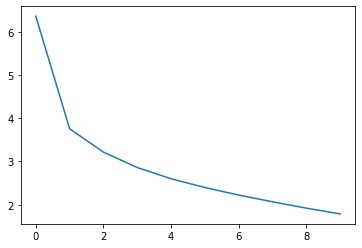

In [ ]:
plt.plot(train_losses)

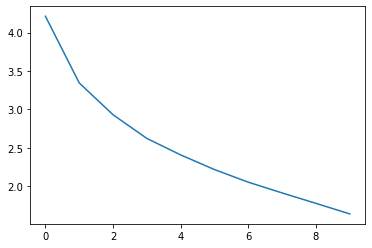

In [ ]:
plt.plot(val_losses)

In [ ]:
sentences = ['지루하다, 놀러가고 싶어..', '오늘 일찍 일어났더니 피곤하다', '간만에 여자친구랑 데이트 하기로 했어.','집에 있는다는 소리야.']
for sen in sentences:
  print(translate(transformer,sen))

 그분 의 삶 을 생각 해 보 세요. 내 서운 의 삶 을 믿 어요. 내보 세요....
 이별 에 는 끝 이 있 을 거 예요.기 가 아니 에요.기 가 아니 에라라. 내 에 에
 저 도 요.!!!!!!!!!!!!!!!!!!!!
 그럴 수 있 어요.치 기운 내요. 내일 을 더 힘들 게 만들 어 주 세요..라 예. 예요.


In [ ]:
NUM_EPOCHS = 10
train_losses =[]
val_losses=[]
for epoch in range(1,NUM_EPOCHS+1):
  train_loss = train_epoch(transformer,optimizer,scheduler)
  val_loss = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.654, Val loss: 1.514


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.521, Val loss: 1.402


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 3, Train loss: 1.405, Val loss: 1.315


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 4, Train loss: 1.306, Val loss: 1.235


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 5, Train loss: 1.220, Val loss: 1.163


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 6, Train loss: 1.147, Val loss: 1.098


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 7, Train loss: 1.088, Val loss: 1.055


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.033, Val loss: 1.007


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.988, Val loss: 0.974


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.950, Val loss: 0.941


In [ ]:
sentences = ['지루하다, 놀러가고 싶어..', '오늘 일찍 일어났더니 피곤하다', '간만에 여자친구랑 데이트 하기로 했어.','집에 있는다는 소리야.']
for sen in sentences:
  print(translate(transformer,sen))

 그럴 만 해요.라 지 세요. 힘들 어요. 기억 을 떠나 보 세요..
 잘 했 어요. 당당 을 위한 투자 만큼 갑진 건 없 어요. 그대로 바라보 세요.. 뿐....
 친구 가 아닌가 봐요.울 수 도 있 겠 네요..뀔 수 있.까요?
 그럴 만 해요.줄게요. 시 대피 방법 을 찾아보 세요...라 면 느껴 지 솔직 하 지 마세요.


In [ ]:
torch.save(transformer.state_dict(), '/content/drive/MyDrive/models/chatbot1')

In [ ]:
NUM_EPOCHS = 20
train_losses =[]
val_losses=[]
for epoch in range(1,NUM_EPOCHS+1):
  train_loss = train_epoch(transformer,optimizer,scheduler)
  val_loss = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.915, Val loss: 0.918


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.886, Val loss: 0.897


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.857, Val loss: 0.879


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.835, Val loss: 0.860


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.814, Val loss: 0.842


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.794, Val loss: 0.833


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.777, Val loss: 0.820


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.759, Val loss: 0.808


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.745, Val loss: 0.799


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.730, Val loss: 0.789


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.717, Val loss: 0.780


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.704, Val loss: 0.772


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.694, Val loss: 0.769


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.682, Val loss: 0.762


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.673, Val loss: 0.757


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.662, Val loss: 0.749


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 17, Train loss: 0.652, Val loss: 0.742


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 18, Train loss: 0.644, Val loss: 0.741


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 19, Train loss: 0.635, Val loss: 0.734


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 20, Train loss: 0.627, Val loss: 0.730


In [ ]:
sentences = ['지루하다, 놀러가고 싶어..', '오늘 일찍 일어났더니 피곤하다', '간만에 여자친구랑 데이트 하기로 했어.','집에 있는다는 소리야.']
for sen in sentences:
  print(translate(transformer,sen))

 잊어버리 세요.은 독 이 됩니다.털 어 버리 세요.. 아니.
 잊어버리 세요.게 제일 슬픈 일 이 에요.질 거 예요..
 같이 식단 조절 을 해 봐요. 그래도 독 이 하 는 것 도 좋 을 거 같 아요.
 갑작스러운 이별 통보 는 받아들이 기 쉽 지 않 죠.복 해서 사랑 이 니까요.쉽 지 않 는 건 아니 에요.


In [ ]:
NUM_EPOCHS = 40
train_losses =[]
val_losses=[]
for epoch in range(1,NUM_EPOCHS+1):
  train_loss = train_epoch(transformer,optimizer,scheduler)
  val_loss = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.621, Val loss: 0.725


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.612, Val loss: 0.716


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.605, Val loss: 0.714


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.599, Val loss: 0.715


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.593, Val loss: 0.716


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.584, Val loss: 0.704


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.578, Val loss: 0.703


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.573, Val loss: 0.702


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.567, Val loss: 0.699


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.561, Val loss: 0.695


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 11, Train loss: 0.556, Val loss: 0.701


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 12, Train loss: 0.552, Val loss: 0.699


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 13, Train loss: 0.546, Val loss: 0.698


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 14, Train loss: 0.541, Val loss: 0.693


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 15, Train loss: 0.536, Val loss: 0.689


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 16, Train loss: 0.532, Val loss: 0.682


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 17, Train loss: 0.527, Val loss: 0.688


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 18, Train loss: 0.524, Val loss: 0.686


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 19, Train loss: 0.517, Val loss: 0.680


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 20, Train loss: 0.512, Val loss: 0.682


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 21, Train loss: 0.509, Val loss: 0.688


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 22, Train loss: 0.507, Val loss: 0.684


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 23, Train loss: 0.503, Val loss: 0.684


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 24, Train loss: 0.500, Val loss: 0.678


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 25, Train loss: 0.496, Val loss: 0.676


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 26, Train loss: 0.493, Val loss: 0.677


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 27, Train loss: 0.489, Val loss: 0.676


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 28, Train loss: 0.487, Val loss: 0.669


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 29, Train loss: 0.483, Val loss: 0.672


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 30, Train loss: 0.481, Val loss: 0.668


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 31, Train loss: 0.476, Val loss: 0.668


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 32, Train loss: 0.472, Val loss: 0.664


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 33, Train loss: 0.469, Val loss: 0.668


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 34, Train loss: 0.468, Val loss: 0.665


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 35, Train loss: 0.465, Val loss: 0.666


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 36, Train loss: 0.461, Val loss: 0.665


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 37, Train loss: 0.459, Val loss: 0.665


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 38, Train loss: 0.458, Val loss: 0.666


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 39, Train loss: 0.455, Val loss: 0.665


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch: 40, Train loss: 0.451, Val loss: 0.667


In [ ]:
sentences = ['지루하다, 놀러가고 싶어..', '오늘 일찍 일어났더니 피곤하다', '간만에 여자친구랑 데이트 하기로 했어.','집에 있는다는 소리야.']
for sen in sentences:
  print(translate(transformer,sen))

 마음 의 준비 를 해야 할지 도 모르 겠 어요.련 만 남 을 뿐 이 에요.라프
 마음 의 짐 을 좀 덜 었 길 바라 요.세요. 실수 하 지 않 길 바라 요..[UNK]시오.
 안 본 웹툰 이 있 는지 먼저 물 어 보 고 싶 네요. 방법 같 아요.
 마음 에 버리 세요. 1 순위 에 자신 을 두 세요.솔직 한 사람 이 될 거 예요.


In [ ]:
print(translate(transformer,'엉뚱한 대답 하고 있네.'))

 하늘 만큼 땅 만큼 축하 해요. 걱정 하 세요. 잠깐 쉬 어가 세요.


# 학습 20 epoch
 저 도 보 고 싶 어요.싶 어요.  
 가끔 핸드폰 없이 살 아 보 세요.  
 가을 타 기 전 새로운 만남 추천 합니다.장 은 항상  
 가끔 은 힘내 지 않 아도 돼요  
# 학습 40epoch
저 도 요! 그게 제일 편한 거 같 아요  
 가끔 은 내키 는 대로 해 보 세요  
 멋지 게 데이트 신청 해 보 세요. 별 이 에서  
 가끔 은 내키 는 대로 해 보  

# 학습 60 epoch
 저 도 궁금 해서 그렇게 하 곤 해요. 적응 에 대한 예요.가벼워질게요.  
 싫 다고 말 하 세요.습관 을 들여 보 세요.  
 애그 샌드위치 추천 합니다. 별 후 에 맞 아요. 별 후 의 여행 은 없 어요.  
 당신 의 이상 형 을 찾아보 세요. 사람 이 있 었 다면절 한 사람 이 든 할 거 예요.  


마지막 결과를 제외한 위의 것들은 학습에 사용한 전처리과정중 빠진 과정이 있어 부족한 점이 보인다. 
이후 재학습 시도.

pandas.DataFrame 인덱스로 dataset은 뭔가 이상하다(range오류관련) 
numpy 로 변경하여 넣어줌.  
학습이 잘 되는것으로 보아 영어,한글은 그 뜻을 연결하는 데에 힘이 들었던 것으로 보임.  
에포크가 증가한다고 해서 학습이 잘 되는 것은 아닌 것으로 보임.(학습 데이터 개수가 적어서 그런 것일 수 도 있음.)